In [31]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import random 
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [8]:
# Removing unstable STRONGs (containing S) from the ML dataset 
csv_data = pd.read_csv('input/ML_data.csv')
csv_data.drop(csv_data.columns[csv_data.columns.str.contains('formation_probability', case=False)], axis=1, inplace=True)
csv_data.drop(csv_data.columns[csv_data.columns.str.contains('formation_energy', case=False)], axis=1, inplace=True)
csv_data.info()

time_constraint = 135
index_names = csv_data[csv_data['formation_time'] <= time_constraint].index 
csv_data.drop(index_names, inplace = True)
csv_data.reset_index(inplace = True)

csv_data.to_csv('input/ML_data_timeconstraint.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20812 entries, 0 to 20811
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pore_number        20812 non-null  int64  
 1   pore_N             20812 non-null  int64  
 2   Canonical_STRONGs  20812 non-null  object 
 3   formation_time     20812 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 650.5+ KB


In [32]:
# Block - Data Pre-processing 

csv_data = pd.read_csv('input/ML_data_timeconstraint.csv')
csv_data.drop(csv_data.columns[csv_data.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
csv_data.drop(csv_data.columns[csv_data.columns.str.contains('index', case=False)], axis=1, inplace=True)
csv_data.info()

train_X, test_X, train_y, test_y = train_test_split(csv_data.Canonical_STRONGs, csv_data.formation_time, test_size = 0.25, random_state = 42)
train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

print(train_X[1])
print(train_y[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20706 entries, 0 to 20705
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pore_number        20706 non-null  int64  
 1   pore_N             20706 non-null  int64  
 2   Canonical_STRONGs  20706 non-null  object 
 3   formation_time     20706 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 647.2+ KB
AAFFFZFFAAFZFFZFFZFZFFZFZFFFSFZFF
200.51


In [33]:
# Block - Data pre-processing (tokenization)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = None, # maximum number of words to keep
    filters="", #find each character after other  
    char_level=True # treat each character as token
)

# updates internal vocabulary based on a list of texts, required before using texts_to_sequences
tokenizer.fit_on_texts(train_X)

In [34]:
# Block - Data pre-processing (padding)

# transforms each text in texts to a sequence of integers, padded to a length of 50
max_len = csv_data.Canonical_STRONGs.map(lambda x: len(x)).max()

train_X = tokenizer.texts_to_sequences(train_X)
padded_train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, padding="post", maxlen = max_len)
test_X = tokenizer.texts_to_sequences(test_X)
padded_test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, padding="post", maxlen = max_len)

print(padded_train_X[1])
print(padded_test_X[15])

[3 3 1 1 1 2 1 1 3 3 1 2 1 1 2 1 1 2 1 2 1 1 2 1 2 1 1 1 4 1 2 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[3 3 1 1 1 2 1 3 3 1 1 2 1 2 1 1 2 1 1 1 3 3 1 2 1 1 2 1 4 1 1 2 1 1 2 1 1
 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
print(max_len)

48


# Hyperparameter Tuning

In [25]:
# K-Fold Cross validation for hyperparameter tuning

def create_model(embedding_dim, gru_units, dense_units, activation):
    # building the model
    model = tf.keras.Sequential()
    # make embedding and indicate that 0 should be treated as padding mask i.e. to ignore 0's
    model.add(tf.keras.layers.Embedding(input_dim=6, output_dim=embedding_dim, mask_zero=True))
    model.add(tf.keras.layers.GRU(gru_units))
    
    for units in dense_units:
        model.add(tf.keras.layers.Dense(units=units, activation=activation))
    
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    return model

In [26]:
# Parameter Grid to be tuned

param_grid = {
    'embedding_dim':[8, 16, 32],
    'gru_units': [16, 32, max_len],
    'dense_units':[[max_len,42,36,30,24,18,12,6,3],[max_len,40,32,24,16,8,4],[max_len,32,16,8,4]],
    'activation': ['relu'], 
}

In [27]:
# Grid search CV (5 fold)

# create the KerasRegressor warpper with the RNN model function
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the cross-validation strategy (K-fold)
cross_validation = KFold(n_splits=5)

# define the GridSearchCV with the model, hyperparameters, and cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= cross_validation, scoring='r2') 

C:\Users\91739\AppData\Local\Temp\ipykernel_9092\3396724561.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [28]:
grid_search.fit(padded_train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001F4AE98A790>,
             param_grid={'activation': ['relu'],
                         'dense_units': [[48, 42, 36, 30, 24, 18, 12, 6, 3],
                                         [48, 40, 32, 24, 16, 8, 4],
                                         [48, 32, 16, 8, 4]],
                         'embedding_dim': [8, 16, 32],
                         'gru_units': [16, 32, 48]},
             scoring='r2')

In [29]:
# Print the best hyperparameters and corresponding R2 score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best R2 Score: ", grid_search.best_score_)

Best Hyperparameters:  {'activation': 'relu', 'dense_units': [48, 32, 16, 8, 4], 'embedding_dim': 16, 'gru_units': 32}
Best R2 Score:  0.00926384405496059


# Sequential Model

In [36]:
# Sequential model developed using hyperparameter obtained from k-fold cross validation


model = tf.keras.Sequential()
 
model.add(tf.keras.layers.Embedding(input_dim=6, output_dim=16, mask_zero=True))
model.add(tf.keras.layers.GRU(32))
   
# ANN start layer
model.add(tf.keras.layers.Dense(max_len, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="relu"))
    
# regression, so no activation
model.add(tf.keras.layers.Dense(1))
    
# compile the model
model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    
# train the model
model_history = model.fit(padded_train_X, train_y, batch_size=32, epochs=250)

Epoch 1/250
486/486 [==============================] - 15s 23ms/step - loss: 6094.8291 - mean_absolute_error: 44.2236
Epoch 2/250
486/486 [==============================] - 11s 22ms/step - loss: 280.4039 - mean_absolute_error: 13.3603
Epoch 3/250
486/486 [==============================] - 11s 23ms/step - loss: 280.3083 - mean_absolute_error: 13.3535
Epoch 4/250
486/486 [==============================] - 11s 22ms/step - loss: 280.6111 - mean_absolute_error: 13.3605
Epoch 5/250
486/486 [==============================] - 11s 23ms/step - loss: 281.7068 - mean_absolute_error: 13.3825
Epoch 6/250
486/486 [==============================] - 11s 23ms/step - loss: 283.1978 - mean_absolute_error: 13.4220
Epoch 7/250
486/486 [==============================] - 11s 23ms/step - loss: 282.1684 - mean_absolute_error: 13.3795
Epoch 8/250
486/486 [==============================] - 11s 22ms/step - loss: 269.1852 - mean_absolute_error: 13.0856
Epoch 9/250
486/486 [==============================] - 11s 22ms

486/486 [==============================] - 11s 23ms/step - loss: 22.6771 - mean_absolute_error: 3.8260
Epoch 72/250
486/486 [==============================] - 10s 21ms/step - loss: 21.7154 - mean_absolute_error: 3.7501
Epoch 73/250
486/486 [==============================] - 11s 23ms/step - loss: 22.9820 - mean_absolute_error: 3.8579
Epoch 74/250
486/486 [==============================] - 11s 22ms/step - loss: 22.1285 - mean_absolute_error: 3.7826
Epoch 75/250
486/486 [==============================] - 15s 30ms/step - loss: 23.0129 - mean_absolute_error: 3.8494
Epoch 76/250
486/486 [==============================] - 10s 22ms/step - loss: 22.0122 - mean_absolute_error: 3.7698
Epoch 77/250
486/486 [==============================] - 10s 22ms/step - loss: 22.4075 - mean_absolute_error: 3.7931
Epoch 78/250
486/486 [==============================] - 11s 22ms/step - loss: 23.7154 - mean_absolute_error: 3.9053
Epoch 79/250
486/486 [==============================] - 11s 22ms/step - loss: 21.9360

486/486 [==============================] - 9s 19ms/step - loss: 20.8099 - mean_absolute_error: 3.6630
Epoch 142/250
486/486 [==============================] - 9s 18ms/step - loss: 20.5128 - mean_absolute_error: 3.6300
Epoch 143/250
486/486 [==============================] - 9s 18ms/step - loss: 20.6215 - mean_absolute_error: 3.6528
Epoch 144/250
486/486 [==============================] - 9s 18ms/step - loss: 20.6034 - mean_absolute_error: 3.6402
Epoch 145/250
486/486 [==============================] - 9s 18ms/step - loss: 21.9064 - mean_absolute_error: 3.7497
Epoch 146/250
486/486 [==============================] - 9s 18ms/step - loss: 20.6643 - mean_absolute_error: 3.6369
Epoch 147/250
486/486 [==============================] - 9s 18ms/step - loss: 20.7108 - mean_absolute_error: 3.6569
Epoch 148/250
486/486 [==============================] - 9s 18ms/step - loss: 21.6616 - mean_absolute_error: 3.7313
Epoch 149/250
486/486 [==============================] - 9s 19ms/step - loss: 20.3967 

486/486 [==============================] - 18s 36ms/step - loss: 20.4760 - mean_absolute_error: 3.6213
Epoch 212/250
486/486 [==============================] - 18s 37ms/step - loss: 19.2630 - mean_absolute_error: 3.5277
Epoch 213/250
486/486 [==============================] - 18s 37ms/step - loss: 20.3243 - mean_absolute_error: 3.6201
Epoch 214/250
486/486 [==============================] - 18s 37ms/step - loss: 20.0478 - mean_absolute_error: 3.5874
Epoch 215/250
486/486 [==============================] - 18s 37ms/step - loss: 20.0842 - mean_absolute_error: 3.5877
Epoch 216/250
486/486 [==============================] - 18s 37ms/step - loss: 19.4501 - mean_absolute_error: 3.5370
Epoch 217/250
486/486 [==============================] - 18s 37ms/step - loss: 20.0862 - mean_absolute_error: 3.5918
Epoch 218/250
486/486 [==============================] - 18s 37ms/step - loss: 19.4645 - mean_absolute_error: 3.5357
Epoch 219/250
486/486 [==============================] - 18s 37ms/step - loss:

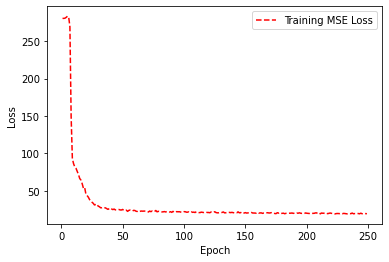

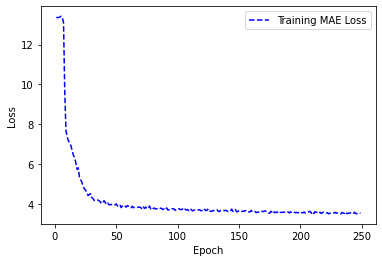

In [37]:
# plotting mse loss
training_mse_loss = model_history.history['loss']
training_mae_loss = model_history.history['mean_absolute_error']

epoch_count = range(1,len(training_mse_loss))

plt.plot(epoch_count, training_mse_loss[1:], 'r--')
plt.legend(['Training MSE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

plt.plot(epoch_count, training_mae_loss[1:], 'b--')
plt.legend(['Training MAE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [38]:
# evaluate on test data
yhat = model.predict(padded_test_X)

# evaluate on train data
yhat_train = model.predict(padded_train_X)

486/486 [==============================] - 5s 9ms/step


test metrics
3.637120981465119
20.628980951630737
0.922865806766733
train metrics
3.4269274430695944
18.280142801170907
0.9341989453850832


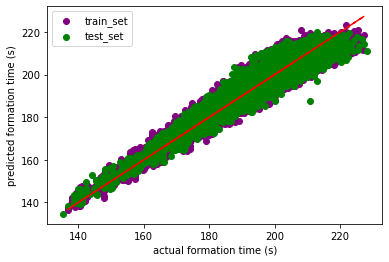

In [39]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat)
mse_test = metrics.mean_squared_error(test_y,yhat)
r2_test = metrics.r2_score(test_y,yhat)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train)
mse_train = metrics.mean_squared_error(train_y,yhat_train)
r2_train = metrics.r2_score(train_y,yhat_train)

print(mae_train)
print(mse_train)
print(r2_train)

plt.scatter(train_y,yhat_train,color = 'purple')
plt.scatter(test_y,yhat, color = 'green')
plt.plot(train_y,train_y, 'r--')
#plt.title('Parity plot')
plt.ylabel('predicted formation time (s)')
plt.xlabel('actual formation time (s)')
plt.legend(['train_set', 'test_set'])
plt.show()

# Saving the trained model

In [40]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

In [41]:
# save the model to disk
filename = 'output/formation_time/formationtime_constrainttime_model.h5'
save_model(model, filename)

# Loading the saved model

In [42]:
# load the model from disk
filename = 'output/formation_time/formationtime_constrainttime_model.h5'
loaded_model = load_model(filename)

In [43]:
# evaluate on train and test data
yhat_test_loaded = loaded_model.predict(padded_test_X)
yhat_train_loaded = loaded_model.predict(padded_train_X)

486/486 [==============================] - 3s 6ms/step


In [44]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat_test_loaded)
mse_test = metrics.mean_squared_error(test_y,yhat_test_loaded)
r2_test = metrics.r2_score(test_y,yhat_test_loaded)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train_loaded)
mse_train = metrics.mean_squared_error(train_y,yhat_train_loaded)
r2_train = metrics.r2_score(train_y,yhat_train_loaded)

print(mae_train)
print(mse_train)
print(r2_train)

test metrics
3.637120981465119
20.628980951630737
0.922865806766733
train metrics
3.4269274430695944
18.280142801170907
0.9341989453850832


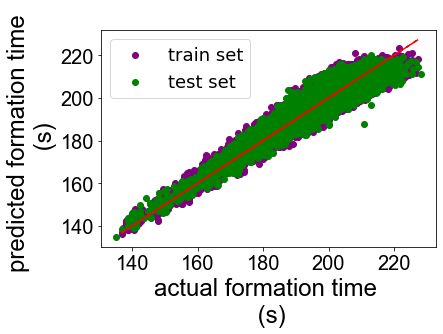

In [45]:
plt.scatter(train_y,yhat_train_loaded,color = 'purple')
plt.scatter(test_y,yhat_test_loaded, color = 'green')
plt.plot(train_y,train_y, 'r--')

plt.ylabel('predicted formation time \n (s)', fontname="Arial", fontsize=24)
plt.xlabel('actual formation time \n (s)', fontname="Arial", fontsize=24)
plt.legend(['train set', 'test set'], fontsize="18", )
plt.xticks(fontsize=20, fontname="Arial")
plt.yticks(fontsize=20, fontname="Arial")
plt.savefig("figures/formation_time/pp_ft_constrainttime.png", format="png", dpi=1600, bbox_inches='tight')
plt.show()